In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Supported Device: ", DEVICE)

Supported Device:  cuda


In [2]:
# EXT_SRC: It contains 1 million randomly selected and shuffled rows from the original dataset.

ROOT = Path("/kaggle/input/leap-atmospheric-physics-ai-climsim")
EXT_SRC = Path("/kaggle/input/leap-train-dataset-complete-perquet")

# 1. Change this train path
TRAIN_PATH = EXT_SRC / "leap_train_batch_1.parquet"
TEST_PATH = ROOT / "test.csv"
SUBMISSION_PATH = ROOT / "sample_submission.csv"

NUM_EPOCHS = 50
BATCH_SIZE = 1024
LEARNING_RATE = 1e-3
ERR = 1e-6

TRAIN_SIZE = 950000
VALID_SIZE = 50000

DIM_FEATURES = 556
DIM_TARGETS = 368

In [3]:
ID = "sample_id"

# INPUT COLUMNS

STATE_PS = "state_ps"

PBUF_SOLIN = "pbuf_SOLIN"
PBUF_LHFLX = "pbuf_LHFLX"
PBUF_SHFLX = "pbuf_SHFLX"
PBUF_TAUX = "pbuf_TAUX"
PBUF_TAUY = "pbuf_TAUY"
PBUF_COSZRS = "pbuf_COSZRS"

CAM_IN_ALDIF = "cam_in_ALDIF"
CAM_IN_ALDIR = "cam_in_ALDIR"
CAM_IN_ASDIF = "cam_in_ASDIF"
CAM_IN_ASDIR = "cam_in_ASDIR"
CAM_IN_LWUP = "cam_in_LWUP"
CAM_IN_ICEFRAC = "cam_in_ICEFRAC"
CAM_IN_LANDFRAC = "cam_in_LANDFRAC"
CAM_IN_OCNFRAC = "cam_in_OCNFRAC"
CAM_IN_SNOWHLAND = "cam_in_SNOWHLAND"

STATE_U = ['state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59']
STATE_V = ['state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59']
STATE_T = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59']

STATE_Q0001 = ['state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59']
STATE_Q0002 = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59']
STATE_Q0003 = ['state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59']

PBUF_OZONE = ['pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59']
PBUF_CH4 = ['pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59']
PBUF_N2O = ['pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']

# OUTPUT COLUMNS

CAM_OUT_NETSW = "cam_out_NETSW"
CAM_OUT_FLWDS = "cam_out_FLWDS"
CAM_OUT_PRECSC = "cam_out_PRECSC"
CAM_OUT_PRECC = "cam_out_PRECC"
CAM_OUT_SOLS = "cam_out_SOLS"
CAM_OUT_SOLL = "cam_out_SOLL"
CAM_OUT_SOLSD = "cam_out_SOLSD"
CAM_OUT_SOLLD = "cam_out_SOLLD"

PTEND_Q0001 = ['ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59']
PTEND_Q0002 = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59']
PTEND_Q0003 = ['ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59']

PTEND_U = ['ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59']
PTEND_V = ['ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59']
PTEND_T = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59']

# REPLACEMENT COLUMNS

REPLACE_FROM = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26']
REPLACE_TO = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26']

# TARGET WEIGHTS

TARGET_WEIGHTS = [30981.265271661872, 22502.432413914863, 18894.14713004499, 14514.244730542465, 10944.348069459196, 9065.01072024503, 9663.669038687454, 12688.557362943708, 19890.17226527665, 25831.37317235381, 33890.367561807274, 44122.94111025334, 59811.25595068309, 79434.07500078829, 107358.80916894016, 135720.8418348218, 149399.8411114814, 128492.95185325432, 91746.23687305572, 72748.76911097553, 66531.53596840335, 62932.30598423903, 56610.26874314136, 49473.14369220607, 43029.18495420936, 36912.67491908133, 31486.93117928144, 26898.072997215502, 23316.638282978325, 20459.73133196152, 18385.68309639014, 17111.405107656312, 16337.80991958771, 15857.759882318944, 15580.902485189716, 15497.59045982052, 15612.2556996736, 15797.88455410361, 15974.218740897895, 16130.395527176632, 16261.310866446129, 16371.892401608216, 16397.019695140876, 16325.463899570548, 16228.641108112768, 16191.809643436269, 16341.207925934068, 16645.711351490587, 17005.493716683693, 17430.29874509864, 17907.24023203076, 18431.55334008694, 19032.471309392287, 19701.355113141435, 20408.236605392685, 20967.20795006453, 21194.427318009974, 21088.521528526755, 19437.91555757985, 13677.902713248171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 871528441401.8333, 1083221770553.0684, 147034752676.7702, 35556045575.13566, 35153369257.41337, 46086368691.51654, 24689305171.692936, 11343276593.440475, 5396624651.94418, 2449353007.641508, 1132225885.703891, 579547849.1340877, 330219246.7861086, 207613930.3131764, 144580292.27473342, 109933282.92266414, 88706603.092171, 73819777.54163922, 63615988.74519494, 57250262.292053565, 52976073.06761927, 49653169.17819005, 46544975.11484598, 43167606.9599748, 39724375.20499403, 36317177.25886468, 33057511.80930482, 29869089.497658804, 26982386.85583376, 24416235.17215712, 22273651.697369896, 20553426.04804544, 19216240.03357431, 18167694.44812838, 17501855.536957663, 17169938.630597908, 17005382.258644175, 16998475.26752617, 17082890.987979066, 17227982.77516062, 17445823.21630204, 17757404.421785507, 18346092.75160569, 19400573.66632694, 20506722.48296608, 22469648.380506545, 23432031.455169585, 26204163.40545158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 3673829810926.31, 371405570725.2526, 14219163611.984406, 3001863018.1934915, 1432766589.9326108, 884599805.0283787, 560127980.1033351, 386052567.7087711, 287331851.051439, 222703657.59538063, 181069239.6264349, 154620864.3164144, 138093777.60284117, 126605828.89875436, 117967840.02553518, 111005814.39518328, 105186901.20678852, 100168133.0295481, 95568646.67416307, 91457433.39515457, 88871610.45308323, 88829796.26374224, 91398113.73291488, 96585131.67000748, 104507692.01463065, 115895119.998433, 131939701.08213414, 154492946.00677127, 183147918.17086875, 215151374.22324687, 247158314.6345976, 266792879.42215955, 279115128.29108113, 370541510.87006927, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 877670509694.7871, 1174826943136.8308, 1270605570069.038, 21727315470.5208, 3159456646.5437946, 1090653401.282219, 727967089.8459107, 384399548.9506704, 290787296.9451616, 232703218.45048887, 197467462.7577736, 174310890.8025987, 160536437.73297343, 153567098.77048483, 152120124.9453068, 153115566.6756177, 153955545.42558223, 153734675.21565756, 154798666.36905554, 163346213.58113608, 180013139.3707387, 200324358.8534948, 220754613.1646765, 241290935.478592, 262868932.2066308, 284448910.01847774, 305681084.4142859, 327605088.8575117, 350473296.7263526, 373964594.1196182, 398396925.8173239, 423528355.65716046, 450447055.544388, 478857006.4973163, 508200335.7126168, 537309657.5789208, 566854568.2904652, 594618842.9455439, 619715928.2391286, 641395460.8414665, 663290039.7810476, 689274894.631561, 718208866.3397261, 743951200.8024124, 761776104.2945968, 772911224.3082078, 804001144.8046833, 772448774.7758856, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4613823.568205323, 1999308.9343799097, 904636.2296014762, 433823.6123842511, 207201.39055371704, 107836.09164720173, 57647.915219220784, 40606.52305039815, 47739.86647922776, 51669.35493930698, 56438.19768395407, 60447.45665200092, 65251.4153955275, 71920.88588011517, 78529.58115204438, 83422.30217897324, 87036.98552475807, 90389.72631774022, 93982.39165674087, 97578.0099352472, 101428.21366062944, 104630.69200130588, 105685.04322626138, 103962.58423268417, 99650.31670632094, 94290.49986206587, 89514.90144353417, 85905.45713126978, 82784.9857650212, 79152.28707014346, 74847.81017353121, 70378.81859610273, 65420.04643792357, 59953.75184604176, 54764.28281143022, 50362.51288353384, 46212.571031725325, 41997.52779088816, 37692.05148110484, 33834.73460995647, 31846.09764364542, 31934.145655397457, 31454.81247448105, 30105.4073072481, 26957.830283611693, 27760.04479210889, 29853.374336459365, 19133.428743715107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7619940.584531054, 3148394.472742347, 1308415.0022178134, 540515.7720745018, 215237.1053603881, 102546.7276372816, 68453.67122640925, 50692.59053608593, 51487.52043139844, 52104.76838400132, 54019.39151917722, 55856.02168787862, 60347.30240270209, 68990.96019017675, 79096.88768563846, 87574.33453690328, 94158.56052476274, 101903.63670531697, 111746.9753834774, 122460.65399236557, 132086.69387474353, 141041.48571028374, 146354.09441287292, 145953.09590059065, 139496.8007888401, 128508.85108217449, 116665.51769667884, 107458.39706309135, 100259.97236694951, 94108.98505029618, 88439.89456238014, 82734.9027659809, 77061.08621371102, 71333.5319243128, 65999.72532130677, 61798.9972058361, 58237.356419617165, 54715.10266341248, 50825.84431702935, 46059.17688689915, 40740.26050401376, 36335.80228304863, 33981.57568605091, 33589.7143390849, 33988.88524112733, 36272.9364507092, 41183.34413717943, 29194.12369278645, 0.0040536134869726, 0.0138824238058072, 135129884.5084534, 12219717.5342461, 0.0090705273332672, 0.0085898851680217, 0.0215368188774867, 0.0336321308942602]

# FEATURE & TARGET LIST

FEATURE_NAMES = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59', 'state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59', 'state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59', 'state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59', 'state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59', 'state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59', 'state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND', 'pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59', 'pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59', 'pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']
TARGET_NAMES = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

In [4]:
ID_IDX = 0

STATE_PS_IDX = 360

PBUF_SOLIN_IDX = 361
PBUF_LHFLX_IDX = 362
PBUF_SHFLX_IDX = 363
PBUF_TAUX_IDX = 364
PBUF_TAUY_IDX = 365
PBUF_COSZRS_IDX = 366

CAM_IN_ALDIF_IDX = 367
CAM_IN_ALDIR_IDX = 368
CAM_IN_ASDIF_IDX = 369
CAM_IN_ASDIR_IDX = 370
CAM_IN_LWUP_IDX = 371
CAM_IN_ICEFRAC_IDX = 372
CAM_IN_LANDFRAC_IDX = 373
CAM_IN_OCNFRAC_IDX = 374
CAM_IN_SNOWHLAND_IDX = 375

CAM_OUT_NETSW_IDX = 360
CAM_OUT_FLWDS_IDX = 361
CAM_OUT_PRECSC_IDX = 362
CAM_OUT_PRECC_IDX = 363
CAM_OUT_SOLS_IDX = 364
CAM_OUT_SOLL_IDX = 365
CAM_OUT_SOLSD_IDX = 366
CAM_OUT_SOLLD_IDX = 367

STATE_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
STATE_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
STATE_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

STATE_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
STATE_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
STATE_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PBUF_OZONE_IDX = [376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
PBUF_CH4_IDX = [436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]
PBUF_N2O_IDX = [496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555]

PTEND_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
PTEND_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
PTEND_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PTEND_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
PTEND_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
PTEND_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [5]:
def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """
    
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()

In [6]:
def calc_mean_std(ds_data:Dataset) -> None:
    """
    Calculate and set the global mean and standard deviation for the dataset features and targets.
    
    Parameters
    ----------
    ds_data : torch.utils.data.Dataset
        Dataset containing the data for which mean and standard deviation are to be calculated. 
        It should have attributes `x` and `y` representing features and targets, respectively.

    Returns
    -------
    None
    """
    
    global X_MEAN, X_STD, Y_MEAN, Y_STD
    
    x = ds_data.x
    y = ds_data.y
    
    X_MEAN = torch.mean(x, 0)
    X_STD = torch.maximum(torch.std(x, 0), torch.tensor(ERR))
    
    Y_MEAN = y.mean(axis=0)
    Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR))

In [7]:
def train_fn(
    model: nn.Module, 
    loader: DataLoader, 
    optimizer: optim.Optimizer, 
    criterion: nn.Module,
) -> float:
    """
    Train the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    loader : torch.utils.data.DataLoader
        DataLoader for the training data.
    optimizer : torch.optim.Optimizer
        Optimizer used for the backpropagation.
    criterion : torch.nn.Module
        Loss function used to compute the loss between the predicted and true values.

    Returns
    -------
    float
        The average training loss over the epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model = model.to(torch.float64).to(DEVICE)
    model.train()
    train_loss = 0
    
    for step, batch in progress_bar:
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            'train_loss': train_loss / step,
        })
        
    return train_loss

In [8]:
def valid_fn(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)
            
            y = y.cpu()
            y = (y * Y_STD) + Y_MEAN
            
            y_pred = y_pred.cpu()
            y_pred[:, Y_STD < (1.1 * ERR)] = 0
            y_pred = (y_pred * Y_STD) + Y_MEAN
            
            val_score += r2_score(y_pred, y)
            
            progress_bar.set_postfix({
                'valid_score': val_score / step,
            })
            
    return val_score

In [9]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model = model.to(torch.float64).to(DEVICE)
    model.eval()

    x_test = df_test[FEATURE_NAMES]
    x_test = x_test.to_numpy()
    x_test = torch.from_numpy(x_test)
    
    x_test = (x_test - X_MEAN) / X_STD
    
    x_test = x_test.to(torch.float64)
    x_test = x_test.to(DEVICE)

    with torch.no_grad():
        y_pred = model(x_test)
        
    y_pred = y_pred.cpu()
    y_pred = y_pred.to(torch.float64)
    
    y_pred[:, Y_STD < (1.1 * ERR)] = 0
    y_pred = (y_pred * Y_STD) + Y_MEAN
    
    y_pred = y_pred.detach()
    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()
    
    return y_pred

### LeapDataset Class for Handling CSV Data in PyTorch

In [10]:
class LeapDataset(Dataset):
    def __init__(self, file_path, x_features, y_features, y_weights):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        data = pl.read_parquet(file_path)
        
        self.x = data[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        
        self.y = data[y_features]
        self.y = self.y.to_numpy()
        self.y = torch.from_numpy(self.y)
        
        self.y = self.y * y_weights
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        x = (x - X_MEAN) / X_STD
        y = (y - Y_MEAN) / Y_STD
        
#         x = x.to(torch.float32)
#         y = y.to(torch.float32)
        
        return x, y
    
    def __len__(self):
        return len(self.y)

### Custom Model

In [11]:
class LeapModel(nn.Module):
    def __init__(self, dims:list):
        """
        Initializes the LeapModel.

        Parameters
        ----------
        dims : list of int
            A list containing the dimensions of each layer in the network. 
            The length of the list determines the number of layers.
        """
        
        super().__init__()
        
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LayerNorm(dims[i + 1]))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        y = self.network(x)
        return y

### Creating Data Loaders for Training and Validation

In [12]:
ds_data = LeapDataset(
    file_path=TRAIN_PATH,
    x_features=FEATURE_NAMES, 
    y_features=TARGET_NAMES,
    y_weights=torch.tensor(TARGET_WEIGHTS),
)
print(f"Number of rows in the dataset: {len(ds_data)}")

ds_train, ds_valid = random_split(ds_data, [int(round(len(ds_data)*0.95)), int(round(len(ds_data)*0.05))])

train_loader = DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True,
)

valid_loader = DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    drop_last=False,
)

Number of rows in the dataset: 983517


### Mean and Standard Deviation Calculation

In [13]:
calc_mean_std(ds_train.dataset)

print("Mean(x) Shape: ", X_MEAN.shape)
print("Mean(y) Shape: ", Y_MEAN.shape)
print("Std(x) Shape: ", X_STD.shape)
print("Std(y) Shape: ", Y_STD.shape)

Mean(x) Shape:  torch.Size([556])
Mean(y) Shape:  torch.Size([368])
Std(x) Shape:  torch.Size([556])
Std(y) Shape:  torch.Size([368])


### Get Sample Batch From Train Dataset

In [14]:
X, y = next(iter(train_loader))

print("Batch Shape: ", tuple(X.shape), tuple(y.shape))

Batch Shape:  (1024, 556) (1024, 368)


### Exploratory Data Analysis

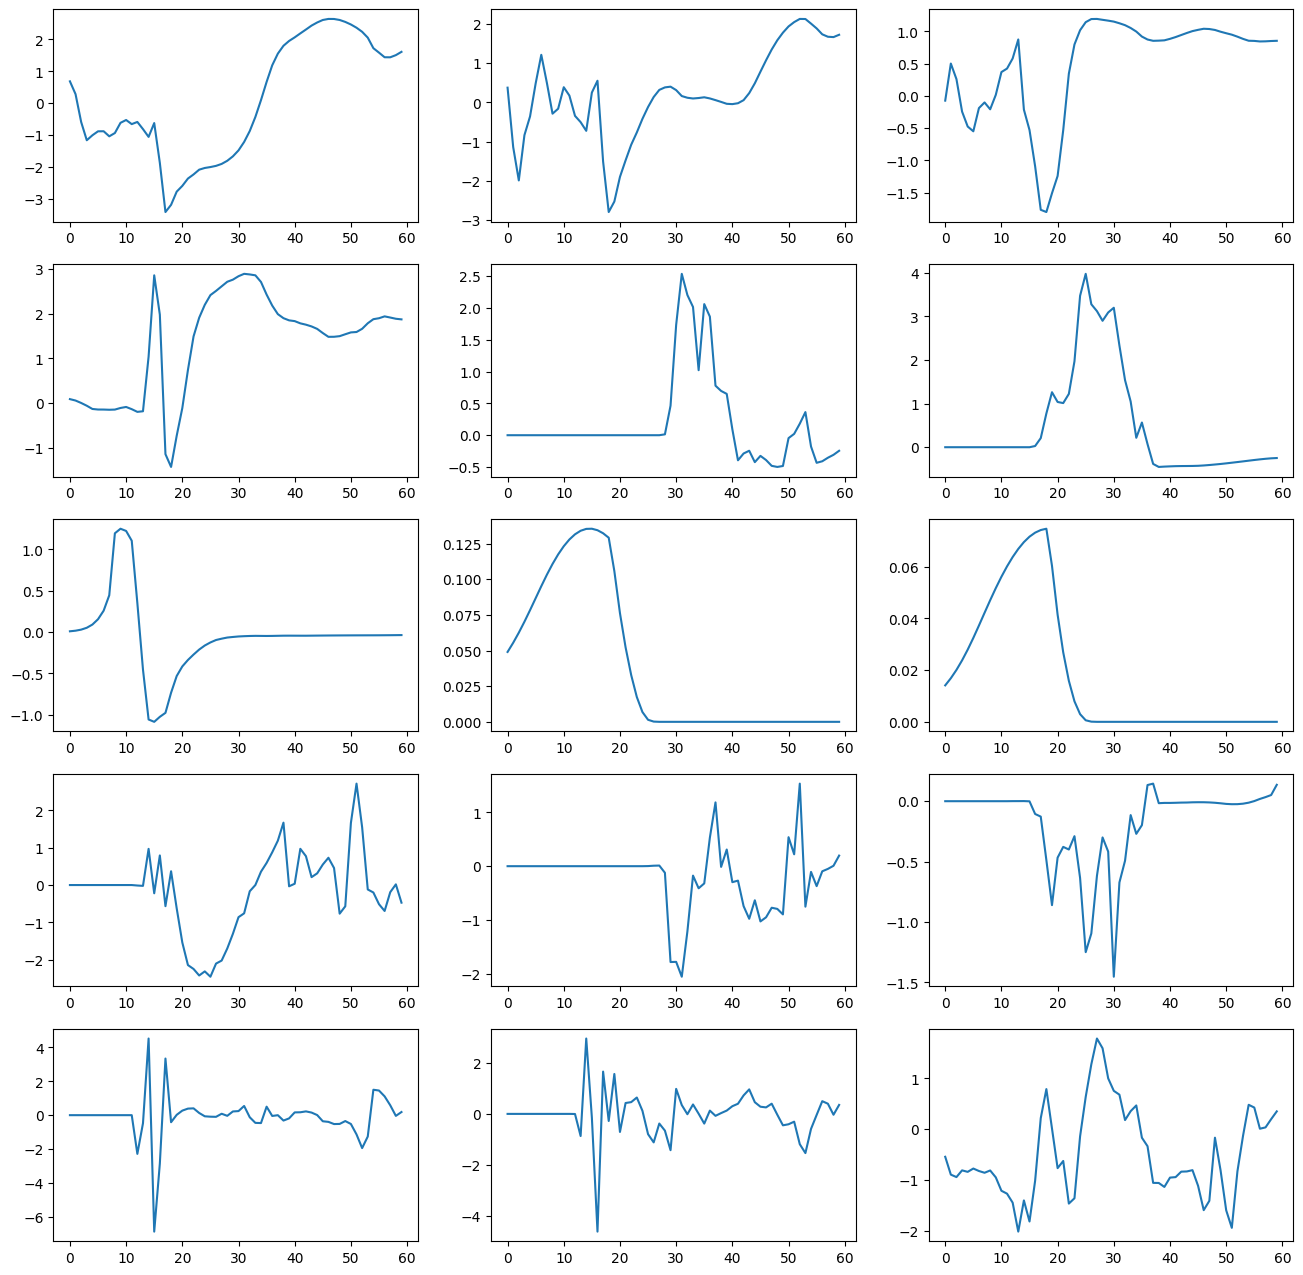

In [15]:
X_point, y_point = X[5], y[5] # nth data point from batch

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

axes[0, 0].plot(X_point[STATE_U_IDX])
axes[0, 1].plot(X_point[STATE_V_IDX])
axes[0, 2].plot(X_point[STATE_T_IDX])

axes[1, 0].plot(X_point[STATE_Q0001_IDX])
axes[1, 1].plot(X_point[STATE_Q0002_IDX])
axes[1, 2].plot(X_point[STATE_Q0003_IDX])

axes[2, 0].plot(X_point[PBUF_OZONE_IDX])
axes[2, 1].plot(X_point[PBUF_CH4_IDX])
axes[2, 2].plot(X_point[PBUF_N2O_IDX])

axes[3, 0].plot(y_point[PTEND_Q0001_IDX])
axes[3, 1].plot(y_point[PTEND_Q0002_IDX])
axes[3, 2].plot(y_point[PTEND_Q0003_IDX])

axes[4, 0].plot(y_point[PTEND_U_IDX])
axes[4, 1].plot(y_point[PTEND_V_IDX])
axes[4, 2].plot(y_point[PTEND_T_IDX])

plt.show()

### Training

In [16]:
model = LeapModel([DIM_FEATURES, 1024, 512, DIM_TARGETS])
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.PolynomialLR(optimizer, power=1.0, total_iters=NUM_EPOCHS)

In [17]:
best_score = -np.inf

for epoch in range(NUM_EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, criterion)
    val_score = valid_fn(model, valid_loader)

    if val_score > best_score:
        best_score = val_score
        torch.save(model.state_dict(), "best_model.pth")

    scheduler.step()

Epoch 49: 100%|██████████████████████████████████| 49/49 [00:03<00:00, 13.89it/s, valid_score=0.575]


### Evaluation

In [18]:
model = LeapModel([DIM_FEATURES, 1024, 512, DIM_TARGETS])
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))

df_test = pl.read_csv(TEST_PATH)
df_test = df_test.to_pandas()
df_test = df_test.set_index("sample_id")

df_subm = pl.read_csv(SUBMISSION_PATH)
df_subm = df_subm.to_pandas()
df_subm = df_subm.set_index("sample_id")

static_pred = -df_test[REPLACE_TO].to_numpy() * df_subm[REPLACE_FROM].to_numpy() / 1200

In [19]:
df_subm.loc[df_test.index, TARGET_NAMES] = pred_fn(model, df_test)

df_subm[REPLACE_FROM] = static_pred

df_subm = df_subm.reset_index()
df_subm = df_subm[["sample_id"] + TARGET_NAMES]

df_subm = pl.from_pandas(df_subm)
df_subm.write_csv("submission.csv")